In [1]:
# Data processing
import pandas as pd
import numpy as np
from datetime import datetime

# Create synthetic time-series data
from statsmodels.tsa.arima_process import ArmaProcess

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Causal impact
from causalimpact import CausalImpact

# Set up a seed for reproducibility
np.random.seed(42)

# Autoregressive coefficients
arparams = np.array([.95, .05])

# Moving average coefficients
maparams = np.array([.6, .3])

# Create a ARMA process
arma_process = ArmaProcess.from_coeffs(arparams, maparams)

# Create the control time-series
X = 10 + arma_process.generate_sample(nsample=500)

# Create the response time-series
y = 2 * X + np.random.normal(size=500)

# Add the true causal impact
y[300:] += 10

In [10]:
# Create dates
dates = pd.date_range('2021-01-01', freq='D', periods=500)

# Create dataframe
df = pd.DataFrame({'dates': dates, 'y': y, 'X': X}, columns=['dates', 'y', 'X'])

# Set dates as index
df.set_index('dates', inplace=True)

# Take a look at the data
df.head()

#df.to_csv("medium_blog_dataset.csv")

,y,X
dates,,
2021-01-01,21.919606,10.496714
2021-01-02,23.172702,10.631643
2021-01-03,21.278713,11.338640
2021-01-04,26.909878,13.173454
2021-01-05,27.260727,13.955685


In [3]:
# Print out the time series start date
print(f'The time-series start date is :{df.index.min()}')

# Print out the time series end date
print(f'The time-series end date is :{df.index.max()}')

# Print out the intervention start date
print(f'The treatment start date is :{df.index[300]}')

The time-series start date is :2021-01-01 00:00:00
The time-series end date is :2022-05-15 00:00:00
The treatment start date is :2021-10-28 00:00:00


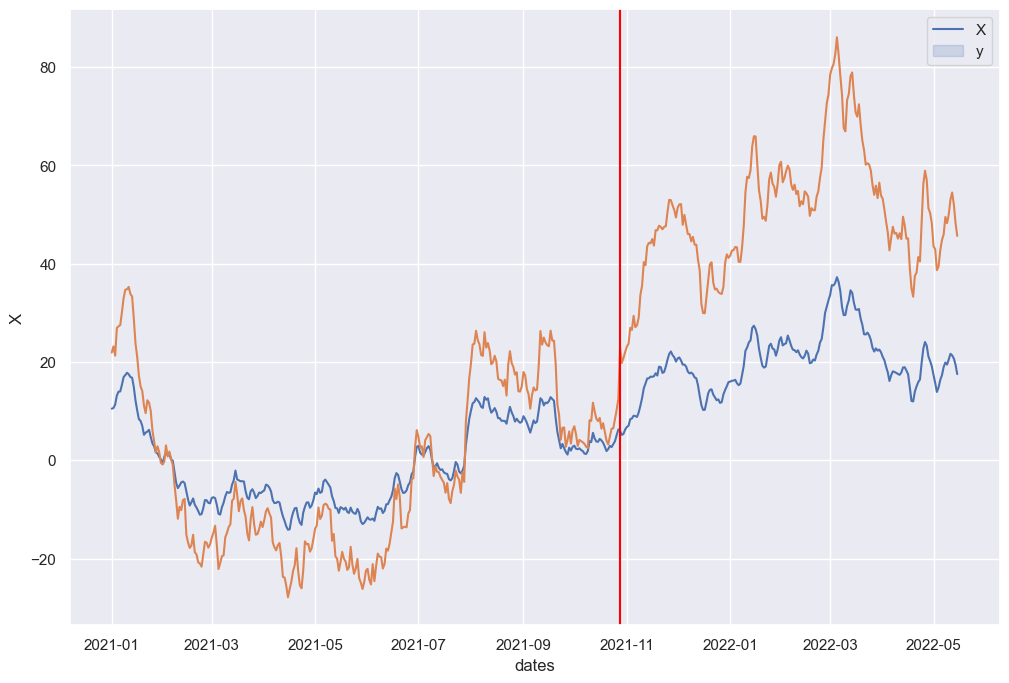

In [4]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=df.index, y=df['X'])
sns.lineplot(x=df.index, y=df['y'])
plt.axvline(x= df.index[300], color='red')
plt.legend(labels = ['X', 'y'])

In [5]:
# Set pre-period
pre_period = [str(df.index.min())[:10], str(df.index[299])[:10]]

# Set post-period
post_period = [str(df.index[300])[:10], str(df.index.max())[:10]]

# Print out the values
print(f'The pre-period is {pre_period}')
print(f'The post-period is {post_period}')

The pre-period is ['2021-01-01', '2021-10-27']
The post-period is ['2021-10-28', '2022-05-15']


In [6]:
# Calculate the pre-daily average
pre_daily_avg = df['y'][:300].mean()

# Calculate the post-daily average
post_daily_avg = df['y'][300:].mean()

# Print out the results
print(f'The pre-treatment daily average is {pre_daily_avg}.')
print(f'The post-treatment daily average is {post_daily_avg}.')
print(f'The raw difference between the pre and the post treatment is {post_daily_avg - pre_daily_avg}.')

The pre-treatment daily average is -1.6403416947312546.
The post-treatment daily average is 50.08461262581729.
The raw difference between the pre and the post treatment is 51.72495432054855.


c:\Users\Reuel Group\anaconda3\envs\causal\lib\site-packages\causalimpact\main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
c:\Users\Reuel Group\anaconda3\envs\causal\lib\site-packages\causalimpact\main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
c:\Users\Reuel Group\anaconda3\envs\causal\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Reuel Group\anaconda3\envs\causal\lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keywor

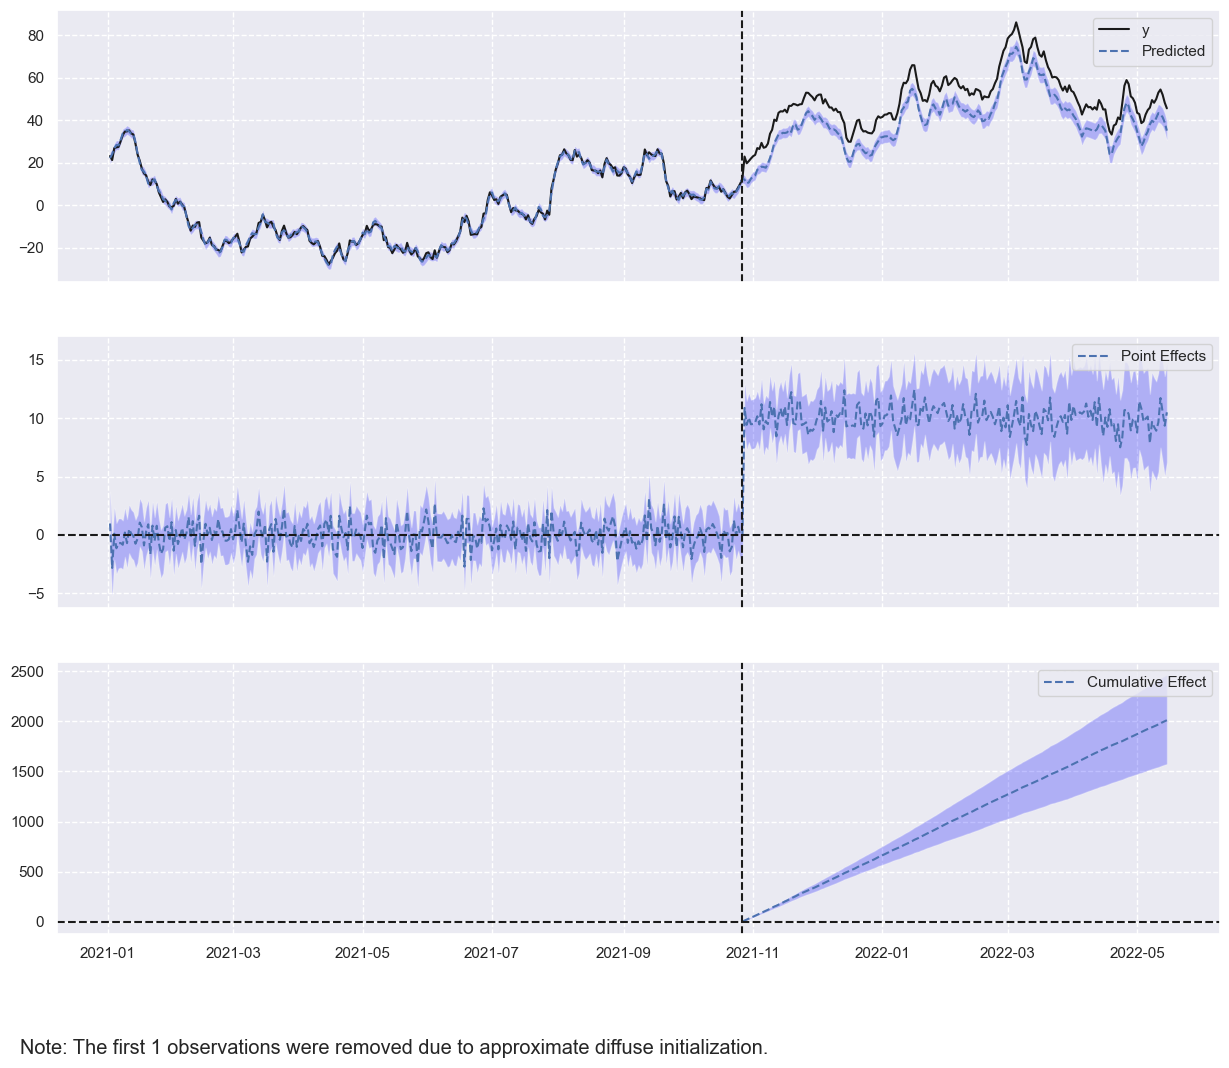

In [7]:
# Causal impact model
impact = CausalImpact(data=df, pre_period=pre_period, post_period=post_period)
# Visualization
impact.plot()

In [8]:
# Causal impact summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    50.08              10016.92
Prediction (s.d.)         40.03 (1.14)       8005.59 (227.62)
95% CI                    [37.75, 42.21]     [7549.9, 8442.16]

Absolute effect (s.d.)    10.06 (1.14)       2011.33 (227.62)
95% CI                    [7.87, 12.34]      [1574.76, 2467.02]

Relative effect (s.d.)    25.12% (2.84%)     25.12% (2.84%)
95% CI                    [19.67%, 30.82%]   [19.67%, 30.82%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [9]:
# Causal impact report
print(impact.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 50.08. By contrast, in the absence of an
intervention, we would have expected an average response of 40.03.
The 95% interval of this counterfactual prediction is [37.75, 42.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 10.06 with a 95% interval of
[7.87, 12.34]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 10016.92.
By contrast, had the intervention not taken place, we would have expected
a sum of 8005.59. The 95% interval of this prediction is [7549.9, 8442.16].


The above results are given in terms of absolute numbers. In relative
terms, the response var